# Learning the Kantorovich Dual using Input Convex Neural Networks

In this tutorial, we explore how to learn the solution of the Kantorovich dual based on parameterizing the two dual potentials $f$ and $g$ with two [input convex neural networks (ICNN)](http://proceedings.mlr.press/v70/amos17b/amos17b.pdf), a method developed by [Makkuva et al. (2020)](http://proceedings.mlr.press/v119/makkuva20a/makkuva20a.pdf). For more insights on the approach itself, we refer the user to the original publication.
Given dataloaders containing samples of the *source* and the *target* distribution, `OTT`'s `NeuralDualSolver` find the pair of optimal potentials $f$ and $g$ to solve the corresponding dual of the optimal transport problem. Once a solution has been found, this can be used to transport unseen source data samples to its target distribution (or vice-versa) or compute the corresponding distance between new source and target distribution.

In [ ]:
!pip install ott-jax

In [2]:
import jax
import jax.numpy as jnp
import numpy as np

import matplotlib.pyplot as plt
from torch.utils.data import IterableDataset
from torch.utils.data import DataLoader
from ott.tools.sinkhorn_divergence import sinkhorn_divergence
from ott.geometry import pointcloud
from ott.core.neuraldual import NeuralDualSolver
from ott.core import icnn

/Users/bunnech/miniforge3/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


## Helper Functions

Let us define some helper functions which we use for the subsequent analysis.

In [3]:
def plot_ot_map(neural_dual, source, target, potential='g'):
    """Plot data and learned optimal transport map."""

    def draw_arrows(a, b):
        plt.arrow(a[0], a[1], b[0] - a[0], b[1] - a[1],
                  color=[0.5, 0.5, 1], alpha=0.3)

    grad_state_s = neural_dual.transport(source, potential)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.scatter(target[:, 0], target[:, 1], color='#A7BED3',
               alpha=0.5, label=r'$target$')
    ax.scatter(source[:, 0], source[:, 1], color='#1A254B',
               alpha=0.5, label=r'$source$')
    if potential == 'g':
        ax.scatter(grad_state_s[:, 0], grad_state_s[:, 1], color='#F2545B',
               alpha=0.5, label=r'$\nabla g(source)$')
    elif potential == 'f':
        ax.scatter(grad_state_s[:, 0], grad_state_s[:, 1], color='#F2545B',
                   alpha=0.5, label=r'$\nabla f(target)$')
    else:
        raise ValueError('Potential is not specified correctly.')

    plt.legend()

    for i in range(source.shape[0]):
        draw_arrows(source[i, :], grad_state_s[i, :])


In [4]:
@jax.jit
def sinkhorn_loss(x, y, epsilon=0.1, power=2.0):
    """Computes transport between (x, a) and (y, b) via Sinkhorn algorithm."""
    a = jnp.ones(len(x)) / len(x)
    b = jnp.ones(len(y)) / len(y)

    sdiv = sinkhorn_divergence(pointcloud.PointCloud, x, y, power=power,
                               epsilon=epsilon, a=a, b=b)
    return sdiv.divergence

## Setup Training and Validation Datasets

We apply the `NeuralDual` to compute the transport between toy datasets. In this tutorial, the user can choose between the datasets `simple` (data clustered in one center), `circle` (two-dimensional Gaussians arranged on a circle), `square_five` (two-dimensional Gaussians on a square with one Gaussian in the center), and `square_four` (two-dimensional Gaussians in the corners of a rectangle).

In [5]:
class ToyDataset(IterableDataset):
    def __init__(self, name):
        self.name = name

    def __iter__(self):
        return self.create_sample_generators()

    def create_sample_generators(self, scale=5.0, variance=0.5):
        # given name of dataset, select centers
        if self.name == "simple":
            centers = np.array([0, 0])

        elif self.name == "circle":
            centers = np.array(
                [
                    (1, 0),
                    (-1, 0),
                    (0, 1),
                    (0, -1),
                    (1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
                    (1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
                    (-1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
                    (-1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
                ]
            )

        elif self.name == "square_five":
            centers = np.array([[0, 0], [1, 1], [-1, 1], [-1, -1], [1, -1]])

        elif self.name == "square_four":
            centers = np.array([[1, 0], [0, 1], [-1, 0], [0, -1]])

        else:
            raise NotImplementedError()

        # create generator which randomly picks center and adds noise
        centers = scale * centers
        while True:
            center = centers[np.random.choice(len(centers))]
            point = center + variance**2 * np.random.randn(2)

            yield point


def load_toy_data(name_source: str,
                  name_target: str,
                  batch_size: int = 1024,
                  valid_batch_size: int = 1024):
    dataloaders = (
      iter(DataLoader(ToyDataset(name_source), batch_size=batch_size)),
      iter(DataLoader(ToyDataset(name_target), batch_size=batch_size)),
      iter(DataLoader(ToyDataset(name_source), batch_size=valid_batch_size)),
      iter(DataLoader(ToyDataset(name_target), batch_size=valid_batch_size)),
    )
    input_dim = 2
    return dataloaders, input_dim

## Solve Neural Dual

In order to solve the neural dual, we need to define our dataloaders. The only requirement is that the corresponding source and target train and validation datasets are *iterators*.

In [6]:
(dataloader_source, dataloader_target, _, _), input_dim = load_toy_data('simple', 'circle')

Next, we define the architectures parameterizing the dual potentials $f$ and $g$. These need to be parameterized by ICNNs. You can adapt the size of the ICNNs by passing a sequence containing hidden layer sizes. While ICNNs are by default containing partially positive weights, we can solve the `NeuralDual` using approximations to this positivity constraint (via weight clipping and a weight penalization). For this, set `positive weights` to True in both the `ICNN` architecture and `NeuralDualSolver` configuration. For more details on how to customize the ICNN architectures, we refer you to the documentation.

In [7]:
icnn_f = icnn.ICNN(dim_hidden=[64, 64, 64, 64])
icnn_g = icnn.ICNN(dim_hidden=[64, 64, 64, 64])

We then initialize the `NeuralDualSolver` by passing the two ICNN models parameterizing $f$ and $g$, as well as by specifying the input dimensions of the data and the number of training iterations to execute. Once the `NeuralDualSolver` is initialized, we can obtain the `NeuralDual` by passing the corresponding dataloaders to it, which will subsequently return the optimal `NeuralDual` for the problem. As here our training and validation datasets do not differ, we pass (`dataloader_source`, `dataloader_target`) for both training and validation steps. For more details on how to configer the `NeuralDualSolver`, we refer you to the documentation.

In [8]:
neural_dual_solver = NeuralDualSolver(
    icnn_f, icnn_g, input_dim=input_dim, num_train_iters=5000)
neural_dual = neural_dual_solver(
    dataloader_source, dataloader_target, dataloader_source, dataloader_target)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [16:56<00:00,  4.92it/s]


## Evaluate Neural Dual

After training has completed successfully, we can evaluate the `NeuralDual` on unseen incoming data. We first sample a new batch from the source and target distribution.

In [9]:
data_source = next(dataloader_source).numpy()
data_target = next(dataloader_target).numpy()

Now we can plot the corresponding transport from source to target using the gradient of the learning potential `NeuralDual.g`, i.e., $\nabla g(\text{source})$, or from target to source via the gradient of the learning potential `NeuralDual.f`, i.e., $\nabla f(\text{target})$.

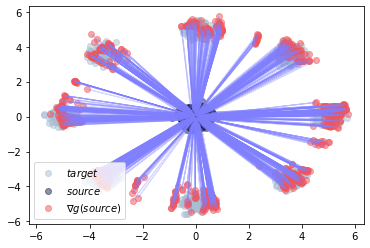

In [10]:
plot_ot_map(neural_dual, data_source, data_target, potential='g')

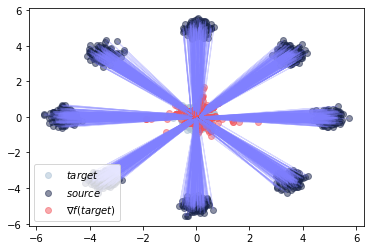

In [11]:
plot_ot_map(neural_dual, data_target, data_source, potential='f')

We further test, how close the predicted samples are to the sampled data.

First for potential $g$, transporting source to target samples. Ideally the resulting Sinkhorn distance is close to 0.

In [12]:
pred_target = neural_dual.transport(data_source, 'g')
print(f'Sinkhorn distance between predictions and data samples: {sinkhorn_loss(pred_target, data_target)}')

Sinkhorn distance between predictions and data samples: 0.5076291561126709


Then for potential $f$, transporting target to source samples. Again, the resulting Sinkhorn distance needs to be close to 0.

In [13]:
pred_source = neural_dual.transport(data_target, 'f')
print(f'Sinkhorn distance between predictions and data samples: {sinkhorn_loss(pred_source, data_source)}')

Sinkhorn distance between predictions and data samples: 0.022719651460647583


Besides computing the transport and mapping source to target samples or vice versa, we can also compute the overall distance between new source and target samples.

In [14]:
neural_dual_dist = neural_dual.distance(data_source, data_target)
print(f'Neural dual distance between source and target data: {neural_dual_dist}')

Neural dual distance between source and target data: 22.057085037231445


Which compares to the primal Sinkhorn distance in the following.

In [15]:
sinkhorn_dist = sinkhorn_loss(data_source, data_target)
print(f'Sinkhorn distance between source and target data: {sinkhorn_dist}')

Sinkhorn distance between source and target data: 22.070484161376953
